Initial Persistence Diagram:


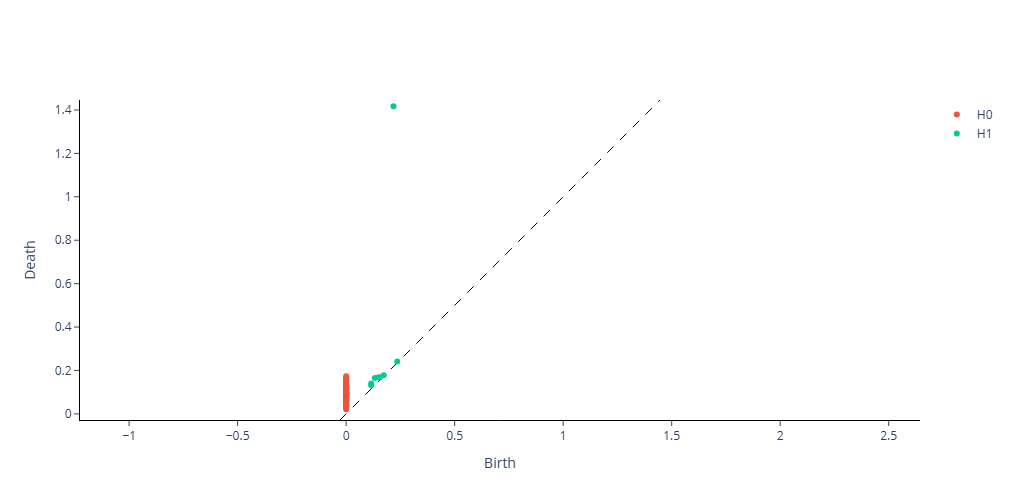

In [1]:
import numpy as np
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram
import matplotlib.pyplot as plt

# Generate a 2D point cloud arranged in an annulus (circle with a hole)
np.random.seed(42)
n_points = 100
theta = np.linspace(0, 2 * np.pi, n_points)
r = np.random.uniform(0.8, 1.0, n_points)
x = r * np.cos(theta) + np.random.normal(0, 0.02, n_points)
y = r * np.sin(theta) + np.random.normal(0, 0.02, n_points)
point_cloud_initial = np.column_stack((x, y))

# Compute and plot the initial persistent homology
vr = VietorisRipsPersistence(homology_dimensions=[0, 1])
diagram_initial = vr.fit_transform([point_cloud_initial])[0]

print('Initial Persistence Diagram:')
plot_diagram(diagram_initial)

In [2]:
import torch
from torch.optim import Adam

# Convert point cloud to a trainable PyTorch tensor
point_cloud_torch = torch.tensor(point_cloud_initial, dtype=torch.float32, requires_grad=True)

# --- THE FIX: A simpler, differentiable geometric loss ---
# This loss encourages all points to move towards the center (0,0), effectively closing the hole.
# This demonstrates the principle of sculpting the manifold via loss minimization.
def geometric_loss(points):
    # Calculate the mean squared distance from the origin
    return torch.mean(points.pow(2))

optimizer = Adam([point_cloud_torch], lr=0.01)
print('Starting optimization to close the loop...')
for epoch in range(200):
    optimizer.zero_grad()
    loss = geometric_loss(point_cloud_torch)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch+1}: Loss = {loss.item():.4f}')
print('Optimization complete.')

Starting optimization to close the loop...
Epoch 20: Loss = 0.2243
Epoch 40: Loss = 0.1096
Epoch 60: Loss = 0.0487
Epoch 80: Loss = 0.0198
Epoch 100: Loss = 0.0073
Epoch 120: Loss = 0.0024
Epoch 140: Loss = 0.0007
Epoch 160: Loss = 0.0002
Epoch 180: Loss = 0.0000
Epoch 200: Loss = 0.0000
Optimization complete.


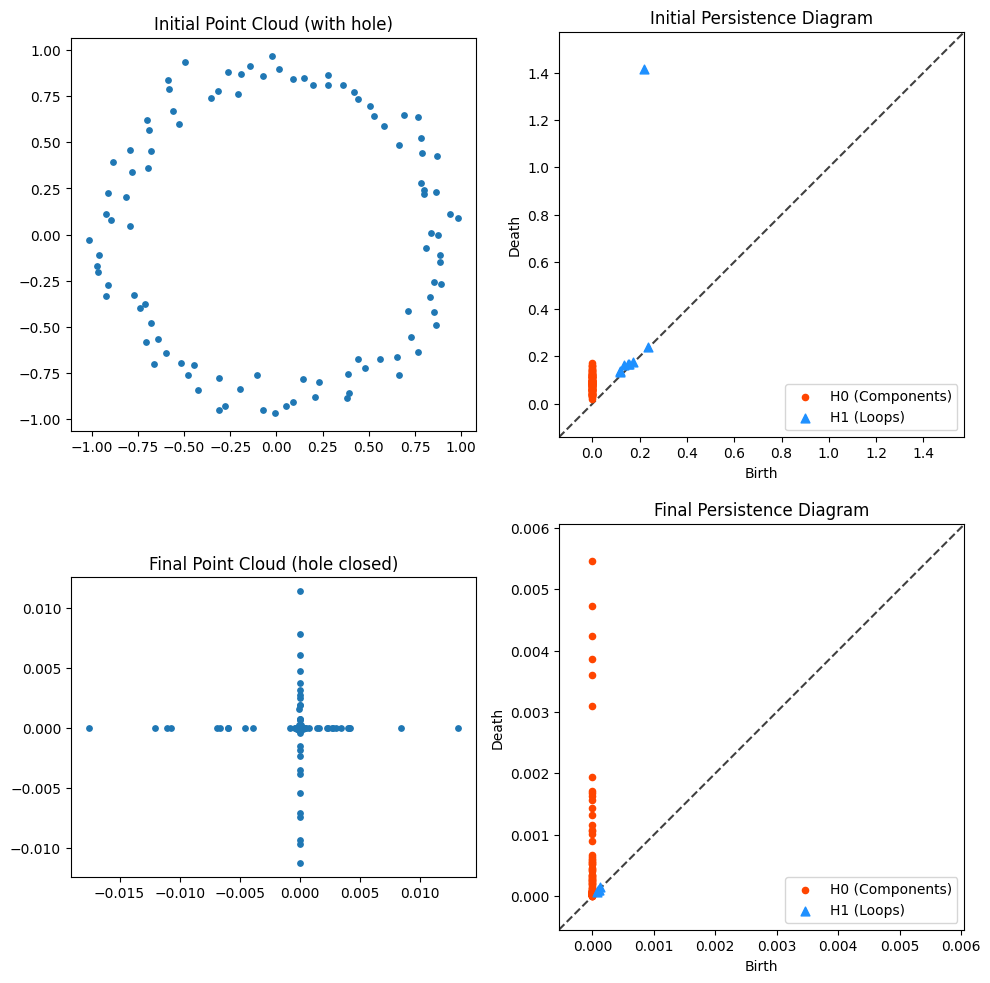

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Get the final point cloud after optimization
point_cloud_final = point_cloud_torch.detach().numpy()

# --- THE FINAL FIX: A manual plotting function to bypass the library's plotter ---
def manual_plot_diagram(diagram, ax, title=""):
    """A robust, manual function to plot a persistence diagram on a given axis."""
    # Filter for H0 (connected components) and H1 (loops)
    h0 = diagram[diagram[:, 2] == 0]
    h1 = diagram[diagram[:, 2] == 1]
    
    # Plot H0 and H1 points with different markers and colors
    ax.scatter(h0[:, 0], h0[:, 1], label='H0 (Components)', c='orangered', s=20, zorder=2)
    ax.scatter(h1[:, 0], h1[:, 1], label='H1 (Loops)', c='dodgerblue', s=40, marker='^', zorder=3)
    
    # Determine the plot limits and draw the y=x diagonal line
    lims = [
        np.min(diagram[:, 0:2]),
        np.max(diagram[:, 0:2])
    ]
    lims[0] -= 0.1 * (lims[1] - lims[0]) # Add a bit of padding
    lims[1] += 0.1 * (lims[1] - lims[0])
    
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=1)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect('equal')
    ax.set_xlabel('Birth')
    ax.set_ylabel('Death')
    ax.set_title(title)
    ax.legend()

# --- Generate plots using our new manual function ---

# Get the raw diagram data
diagram_initial_data = vr.fit_transform(point_cloud_initial[None, :, :])[0]
diagram_final_data = vr.fit_transform(point_cloud_final[None, :, :])[0]

# Create the figure
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# --- Plot initial state ---
axes[0, 0].scatter(point_cloud_initial[:, 0], point_cloud_initial[:, 1], s=15)
axes[0, 0].set_title('Initial Point Cloud (with hole)')
axes[0, 0].set_aspect('equal')

# Use our manual plotter for the initial diagram
manual_plot_diagram(diagram_initial_data, axes[0, 1], title='Initial Persistence Diagram')

# --- Plot final state ---
axes[1, 0].scatter(point_cloud_final[:, 0], point_cloud_final[:, 1], s=15)
axes[1, 0].set_title('Final Point Cloud (hole closed)')
axes[1, 0].set_aspect('equal')

# Use our manual plotter for the final diagram
manual_plot_diagram(diagram_final_data, axes[1, 1], title='Final Persistence Diagram')

plt.tight_layout()
plt.show()